# Table of Contents
* [1. compositon](#1.-compositon)
	* [1.1 characters](#1.1-characters)
	* [1.2 objects](#1.2-objects)
	* [1.3 descriptions](#1.3-descriptions)
* [2. avg appearance](#2.-avg-appearance)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import functools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm as tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import anigen_tools
from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this

In [2]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 1

plt.rc('font',**{'family':'serif','serif':['Times']})
# plt.rc('font', family='serif')
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

plt.rc('text', usetex=True)

In [3]:
dataset = unpickle_this('../build_dataset/pickled_data/dataset_full26k.pkl')

In [4]:
def get_vid(video_id, dataset=dataset):
    return [vid for vid in dataset if vid.gid() == video_id][0]

def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight')

# 1. compositon

## 1.1 characters

In [8]:
vid_count = len(dataset)

In [9]:
char_counts = pd.Series([len(vid.data()['characters']) for vid in dataset])
count_dist = char_counts.value_counts()
norm_count_dist = count_dist / count_dist.sum()

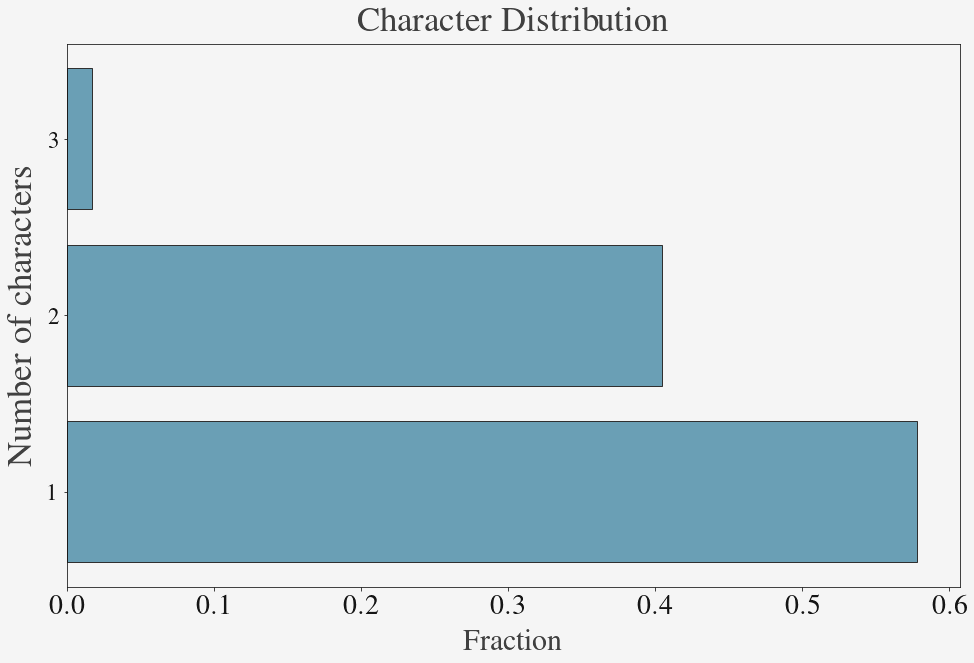

In [10]:
fig_labels = {
    'fig_title': 'Character Distribution', 
    'x_label': 'Fraction',
    'y_label': 'Number of characters'
}

fig = plt.barh(norm_count_dist.index, norm_count_dist.values)
_ = make_standard_fig(fig, fig_labels, save=False)
_ = plt.yticks(np.arange(1, 4, 1))

## 1.2 objects

In [11]:
obj_counts = pd.Series([len(vid.data()['objects']) for vid in dataset])
o_count_dist = obj_counts.value_counts()
norm_o_count_dist = o_count_dist / o_count_dist.sum()

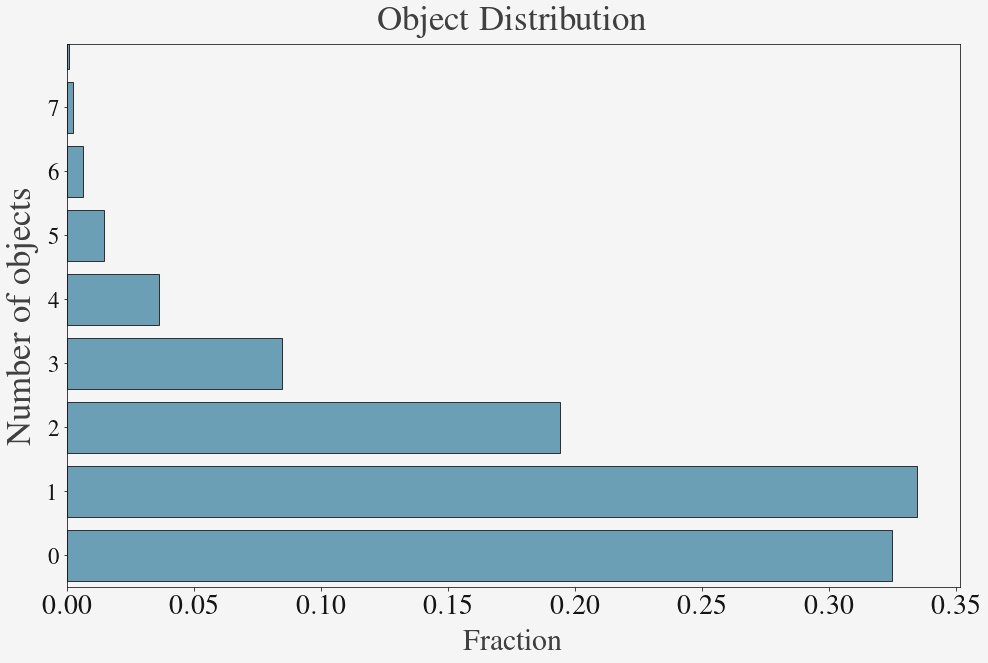

In [12]:
fig_labels = {
    'fig_title': 'Object Distribution', 
    'x_label': 'Fraction',
    'y_label': 'Number of objects'
}

fig = plt.barh(norm_o_count_dist.index, norm_o_count_dist.values)
_ = make_standard_fig(fig, fig_labels, save=True)
_ = plt.yticks(np.arange(0, 8, 1))
_ = plt.ylim(-0.5, 8)

## 1.3 descriptions

In [13]:
desc_lens = pd.Series([len(vid.description().split()) for vid in dataset])

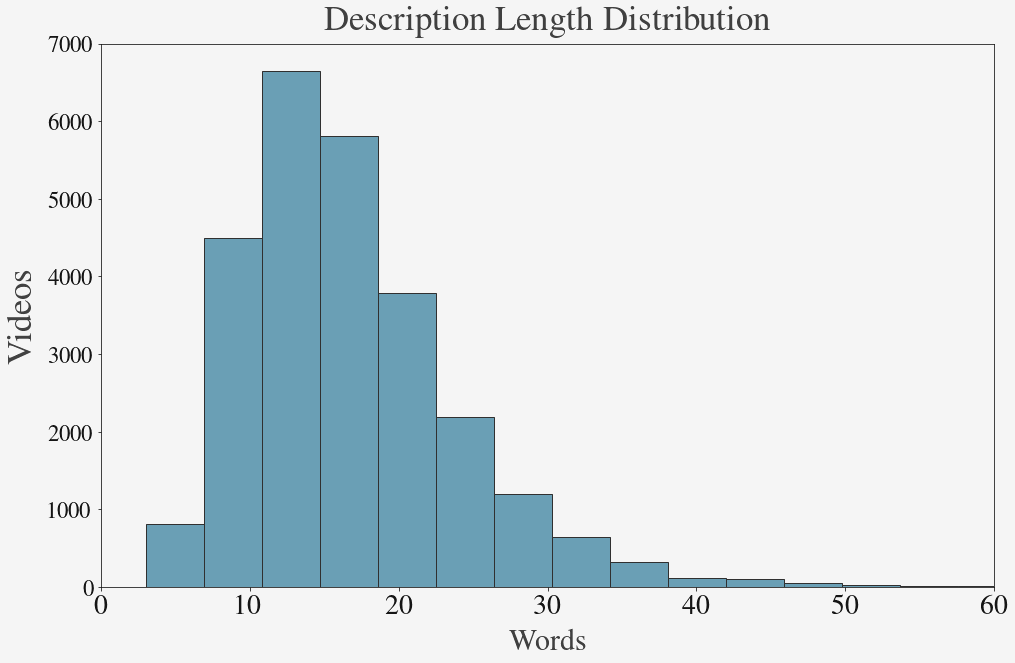

In [14]:
fig_labels = {
    'fig_title': 'Description Length Distribution', 
    'x_label': '# Words',
    'y_label': '# Videos'
}

fig = desc_lens.hist(bins=20)
_ = make_standard_fig(fig, fig_labels, save=False)
# _ = plt.yticks(np.arange(0, 8, 1))
_ = plt.xlim(0, 60)
_ = plt.ylim(0, 7000)

# 2. avg appearance

In [301]:
def filter_chars(vid, n_chars = None, chars_required=None):
    if n_chars:
        len_match =  len(vid.data()['characters']) == n_chars
    else:
        len_match = True
    if chars_required:
        chars_present = set([char.data()['entityLabel'] for char in vid.data()['characters']])
        chars_satisfied = len(set(chars_present).intersection(set(chars_required))) == len(chars_required)
    else:
        chars_satisfied = True
    return len_match and chars_satisfied

def filter_description(vid, contains=[], doesnot_contain=[]):
    contains_satisfied = sum([phrase.lower() in vid.description() for phrase in contains]) == len(contains)        
    doesnot_contains_satisfied = sum([phrase.lower() not in vid.description() for phrase in doesnot_contain]) == len(doesnot_contain)
    return contains_satisfied and doesnot_contains_satisfied


def vid_filter(vid, filters):
    return sum([filt(vid) for filt in filters]) == len(filters)

def avg_video_appearence(videos, viz=False):
    width, height = (640, 480)
    n_imgs = len(videos)
    avg_arr = np.zeros((height, width , 3), np.float)
    for vid in tqdm(videos):
        im = vid.get_key_frame_images(spec_frame=1).pop() 
        img_arr = np.array(im, dtype=np.float)
        avg_arr += img_arr / n_imgs
    avg_arr = np.array(np.round(avg_arr), dtype=np.uint8)
    if viz:
        return pil.fromarray(avg_arr, mode="RGB")
    return avg_arr

In [ ]:
filters_to_apply = [functools.partial(filter_chars, n_chars=1, chars_required=['fred']), functools.partial(filter_description, contains=['phone', 'picks up'])]

In [7]:
vid_list = [vid for vid in dataset if vid_filter(vid, filters_to_apply)]

100%|██████████| 5/5 [00:00<00:00, 31.13it/s]


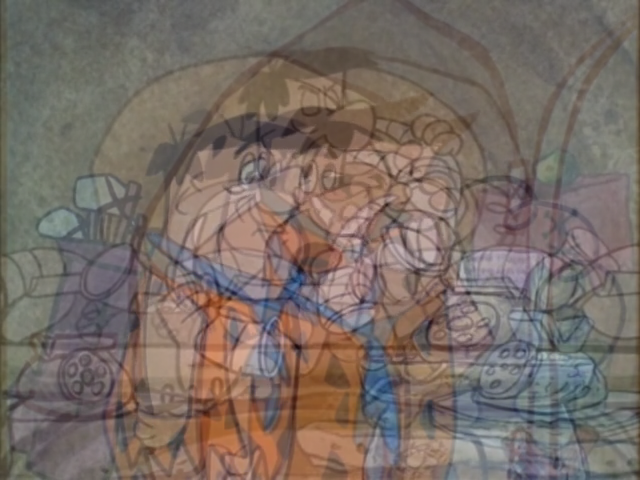

In [10]:
avg_video_appearence(vid_list, 1)

# trajectories

In [15]:
from anigen_tools.tracking import draw_all_bboxes
import numpy_indexed as npi
from anigen_tools.bboxes import comp_box_center

In [11]:
test_obj = vid_list[1].data()['objects'][1]

In [299]:
# vid_list[1].display_gif()

In [25]:
# test_track_array = np.load(os.path.join(data_dir,  tracking_dir, test_obj.gid() + '.npy'))
# frame_arr_data = np.load(os.path.join(data_dir,  'frame_arr_data', vid_list[1].gid() + '.npy'))

In [341]:
data_dir = '/Users/schwenk/wrk/animation_gan/dataset/v2p0/trajectories'
tracking_dir = 'tracking'

def gen_smooth_traj(tracking_arr):
    tracked_obj_centers = np.apply_along_axis(comp_box_center, 1, tracking_arr)
    tracked_obj_centers.sort(axis=0)
    unique_positions = np.unique(tracked_obj_centers, axis=0)
    obj_x = unique_positions[:, 0]
    obj_y = unique_positions[:, 1]
    x_u, y_m = npi.group_by(obj_x).mean(obj_y)
    polyf = np.poly1d(np.polyfit(x_u, y_m, 1))
    xr = np.linspace(x_u[0], x_u[-1], num=400, endpoint=True)
    curve_pts = np.vstack((xr, polyf(xr))).T
    return curve_pts.astype(np.uint16)

def draw_trajectory(traj_img, curve, mag):
    movement_thresh = 10
    n_points = len(curve)
    if curve[-1][0] == 0 or curve[0][0] == 0:
        return
    if np.linalg.norm(curve[-1] - curve[0]) < movement_thresh:
        cv2.circle(traj_img, tuple(curve[0]), 1, (100, 0, 0), -1)
        return
    for idx, point in enumerate(curve):
        p_size = 1
        if idx == 0 or idx == n_points - 1:
            p_size= 4
        pf = idx / n_points
        p_color = (100 * pf, 100 * (1- pf), 0)
        cv2.circle(traj_img, tuple(point), p_size, p_color, -1)

# def draw_trajectory_poly(traj_img, curve, mag):
#     return cv2.polylines(traj_img, np.int32([curve]), False, (mag, mag, mag), thickness=2)

def draw_trajectory_set(videos, ent_label, avg_img=None, mag=50, ent_type = 'objects'):
    if not avg_img.any():
        avg_img = avg_video_appearence(videos)
    to_draw = copy.deepcopy(avg_img)
    for vid in videos:
        try:
            target_ent = [ent for ent in vid.data()[ent_type] if ent_label in ent.data()['entityLabel']].pop()
        except IndexError:
            continue
        traj_layer = np.zeros_like(to_draw)
        try:
            tracking_arr = np.load(os.path.join(data_dir,  tracking_dir, target_ent.gid() + '.npy'))
        except FileNotFoundError:
            pass
        smoothed_traj = gen_smooth_traj(tracking_arr)
        draw_trajectory(traj_layer, smoothed_traj, mag)
        to_draw = cv2.addWeighted(traj_layer, mag, to_draw, 1 , 0)
    return to_draw
#     return traj_layer

In [353]:
filters_to_apply = [functools.partial(filter_chars, n_chars=None, chars_required=['fred']), functools.partial(filter_description, contains=[''])]
vid_list = [vid for vid in dataset if vid_filter(vid, filters_to_apply)]
len(vid_list)

12

In [354]:
avg_image = avg_video_appearence(vid_list)

100%|██████████| 12/12 [00:00<00:00, 41.43it/s]


In [355]:
%%capture
test_draw = draw_trajectory_set(vid_list, 'fred', ent_type='characters', avg_img=avg_image, mag=0.4)

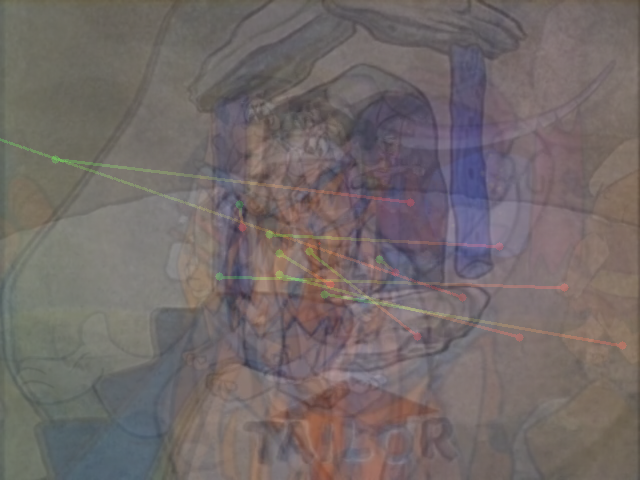

In [356]:
pil.fromarray(test_draw)

In [213]:
# test_vid = get_vid('s_02_e_18_shot_013942_014016')